<a href="https://colab.research.google.com/github/jarekwan/jarwan_projekt/blob/main/PROJECT_DATASCIENCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Introduction

Supplier performance differs in delivery speed, reliability, quality, and cost. Proper segmentation helps identify groups of suppliers with similar characteristics, which supports better procurement decisions, reduces operational risk, and improves supply chain efficiency. Instead of manual, subjective evaluation, data-driven clustering allows companies to quickly detect reliable, risky, or cost-inefficient suppliers.


---

### 2. Business Problem

The goal of this project is to segment suppliers based on performance metrics. This helps detect unreliable or high-defect suppliers, highlight cost-efficient and high-quality ones, and identify risks related to delivery delays. By grouping suppliers automatically, companies can support procurement strategy, plan improvement actions, and make more informed sourcing decisions.


---

### 3. Data Description

The dataset contains numerical features describing different aspects of supplier performance. Each row represents a unique supplier, while the remaining columns store quantitative attributes useful for comparison. These features are suitable for clustering, as they capture variability in supplier behavior and overall performance.


---

### 4. Why This Problem Matters

Supplier segmentation supports better sourcing decisions, helps identify risks, and improves cost and quality control. Without segmentation, important performance differences remain hidden.

---

### 5. Goal of the Analysis

The goal of this analysis is to explore the data, prepare features, reduce dimensionality, and apply clustering methods to identify meaningful supplier groups and extract actionable insights.



### Data Loading

In this step, the dataset is loaded into the notebook. The user can either upload a custom CSV file or generate synthetic supplier data for testing purposes. After loading the data, a unique supplier identifier is selected (or created), and numerical features are extracted for further analysis. This ensures that the dataset is properly structured and ready for exploration and preprocessing.


In [ ]:
# Data handling
import pandas as pd
import numpy as np

# File upload support (Colab)
from google.colab import files
import io

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Feature scaling
from sklearn.preprocessing import StandardScaler

# Dimensionality reduction
from sklearn.decomposition import PCA

# Clustering algorithms
from sklearn.cluster import KMeans, DBSCAN

# Cluster quality metrics
from sklearn.metrics import silhouette_score


# Data source selection
print("Select data source:")
print("1 - Upload CSV file")
print("2 - Generate synthetic data")

choice = input("Enter 1 or 2: ")

if choice == "1":
    # Uploading user dataset
    print("📂 Please select a CSV file...")
    up = files.upload()
    if not up:
        raise ValueError("No file selected.")
    df = pd.read_csv(io.BytesIO(next(iter(up.values()))))
    print("\n✅ CSV file loaded. Shape:", df.shape)
    print(df.head())

    # Selecting supplier ID column
    print("\nAvailable columns:")
    for i, c in enumerate(df.columns):
        print(f"{i}: {c}")
    id_idx = int(input("\nEnter the index of the supplier identifier column: "))
    supplier_col = df.columns[id_idx]

    # Renaming selected column to 'supplier_id'
    df = df.rename(columns={supplier_col: "supplier_id"})
    df["supplier_id"] = df["supplier_id"].astype(str)

    # Selecting numerical features
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

elif choice == "2":
    # Generating synthetic supplier dataset
    n = 2000
    df = pd.DataFrame({
        'supplier_id': [f'S{i}' for i in range(1, n+1)],
        'delivery_time': np.random.normal(5, 1.5, n),
        'reliability': np.random.uniform(0.7, 1.0, n),
        'cost': np.random.normal(100, 15, n),
        'complaints': np.random.randint(0, 5, n)
    })
    print("\n✅ Synthetic dataset generated. Shape:", df.shape)
    print(df.head())

    # Numerical features in synthetic dataset
    num_cols = ['delivery_time', 'reliability', 'cost', 'complaints']

else:
    raise ValueError("❌ Invalid selection. Please restart and enter 1 or 2.")

print("\nℹ️ Proceeding with data analysis...")



Select data source:
1 - Upload CSV file
2 - Generate synthetic data
Enter 1 or 2: 1
📂 Please select a CSV file...


Saving FF.csv to FF (3).csv

✅ CSV file loaded. Shape: (777, 11)
      PO_ID         Supplier  Order_Date Delivery_Date    Item_Category  \
0  PO-00001        Alpha_Inc  2023-10-17    2023-10-25  Office Supplies   
1  PO-00002  Delta_Logistics  2022-04-25    2022-05-05  Office Supplies   
2  PO-00003         Gamma_Co  2022-01-26    2022-02-15              MRO   
3  PO-00004    Beta_Supplies  2022-10-09    2022-10-28        Packaging   
4  PO-00005  Delta_Logistics  2022-09-08    2022-09-20    Raw Materials   

  Order_Status  Quantity  Unit_Price  Negotiated_Price  Defective_Units  \
0    Cancelled      1176       20.13             17.81              NaN   
1    Delivered      1509       39.32             37.34            235.0   
2    Delivered       910       95.51             92.26             41.0   
3    Delivered      1344       99.85             95.52            112.0   
4    Delivered      1180       64.07             60.53            171.0   

  Compliance  
0        Yes  
1  

### Exploratory Data Analysis (EDA)

This step inspects the dataset to understand its structure and guide preprocessing and modeling. We:
- preview a sample of rows;
- check column dtypes and count missing values;
- compute basic descriptive statistics for numerical features;
- select numerical columns (excluding `supplier_id` if numeric);
- visualize distributions with histograms and detect skew or multimodality;
- use boxplots to spot potential outliers;
- flag outliers per feature using the IQR rule (Q1, Q3, 1.5·IQR);
- analyze feature relationships with a correlation heatmap and list the strongest pairs.

Purpose: identify data quality issues, understand variability, detect anomalies, and see which features are related—so later scaling, PCA, and clustering are done on well-understood inputs.


Data preview:


,PO_ID,supplier_id,Order_Date,Delivery_Date,Item_Category,Order_Status,Quantity,Unit_Price,Negotiated_Price,Defective_Units,Compliance
0,PO-00001,Alpha_Inc,2023-10-17,2023-10-25,Office Supplies,Cancelled,1176,20.13,17.81,NaN,Yes
1,PO-00002,Delta_Logistics,2022-04-25,2022-05-05,Office Supplies,Delivered,1509,39.32,37.34,235.0,Yes
2,PO-00003,Gamma_Co,2022-01-26,2022-02-15,MRO,Delivered,910,95.51,92.26,41.0,Yes
3,PO-00004,Beta_Supplies,2022-10-09,2022-10-28,Packaging,Delivered,1344,99.85,95.52,112.0,Yes
4,PO-00005,Delta_Logistics,2022-09-08,2022-09-20,Raw Materials,Delivered,1180,64.07,60.53,171.0,No



Data types:
PO_ID                object
supplier_id          object
Order_Date           object
Delivery_Date        object
Item_Category        object
Order_Status         object
Quantity              int64
Unit_Price          float64
Negotiated_Price    float64
Defective_Units     float64
Compliance           object
dtype: object

Missing values per column:
PO_ID                 0
supplier_id           0
Order_Date            0
Delivery_Date        87
Item_Category         0
Order_Status          0
Quantity              0
Unit_Price            0
Negotiated_Price      0
Defective_Units     136
Compliance            0
dtype: int64

Descriptive statistics:


,Quantity,Unit_Price,Negotiated_Price,Defective_Units
count,777.000000,777.000000,777.000000,641.000000
mean,1094.660232,58.283822,53.660721,74.803432
std,647.844551,28.101315,26.094930,69.187870
min,51.000000,10.840000,9.270000,0.000000
25%,615.000000,33.290000,30.460000,26.000000
50%,1075.000000,58.950000,53.800000,49.000000
75%,1548.000000,83.130000,76.550000,100.000000
max,5000.000000,109.170000,107.390000,321.000000


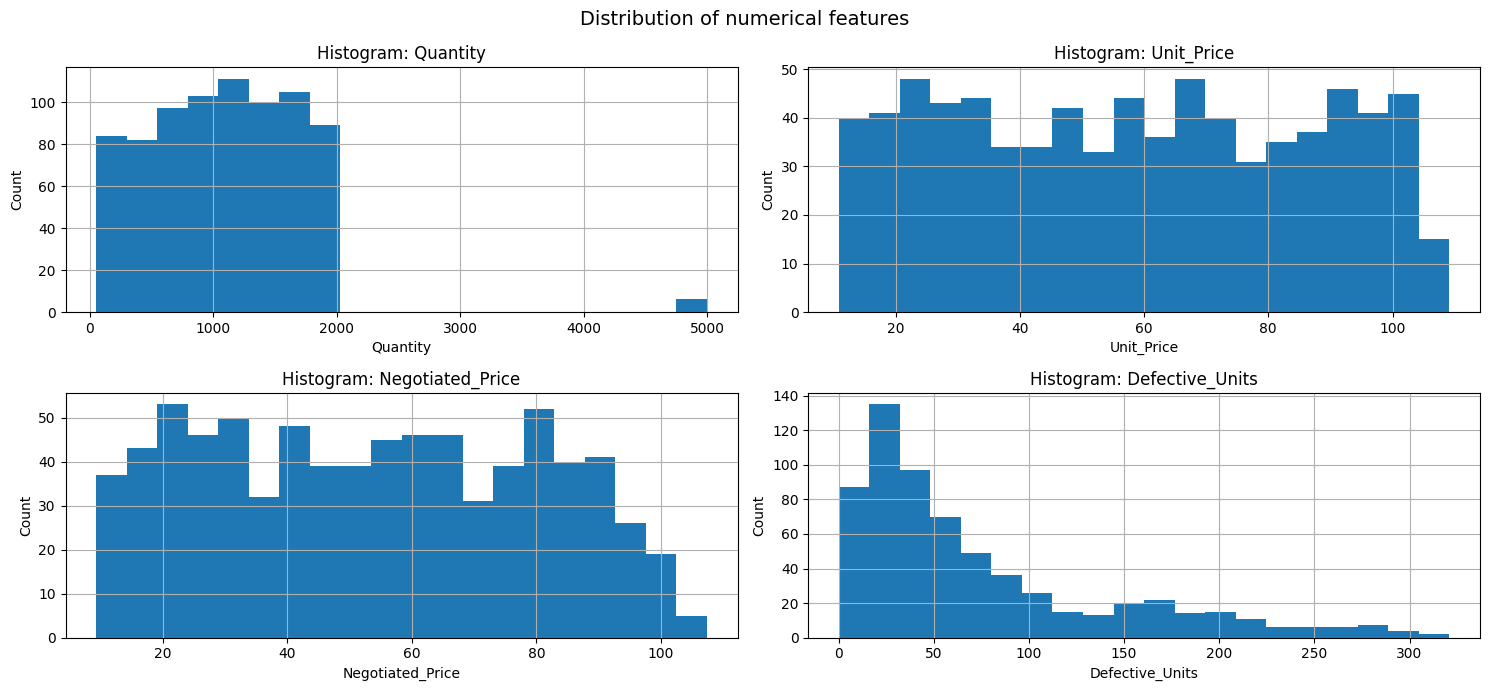

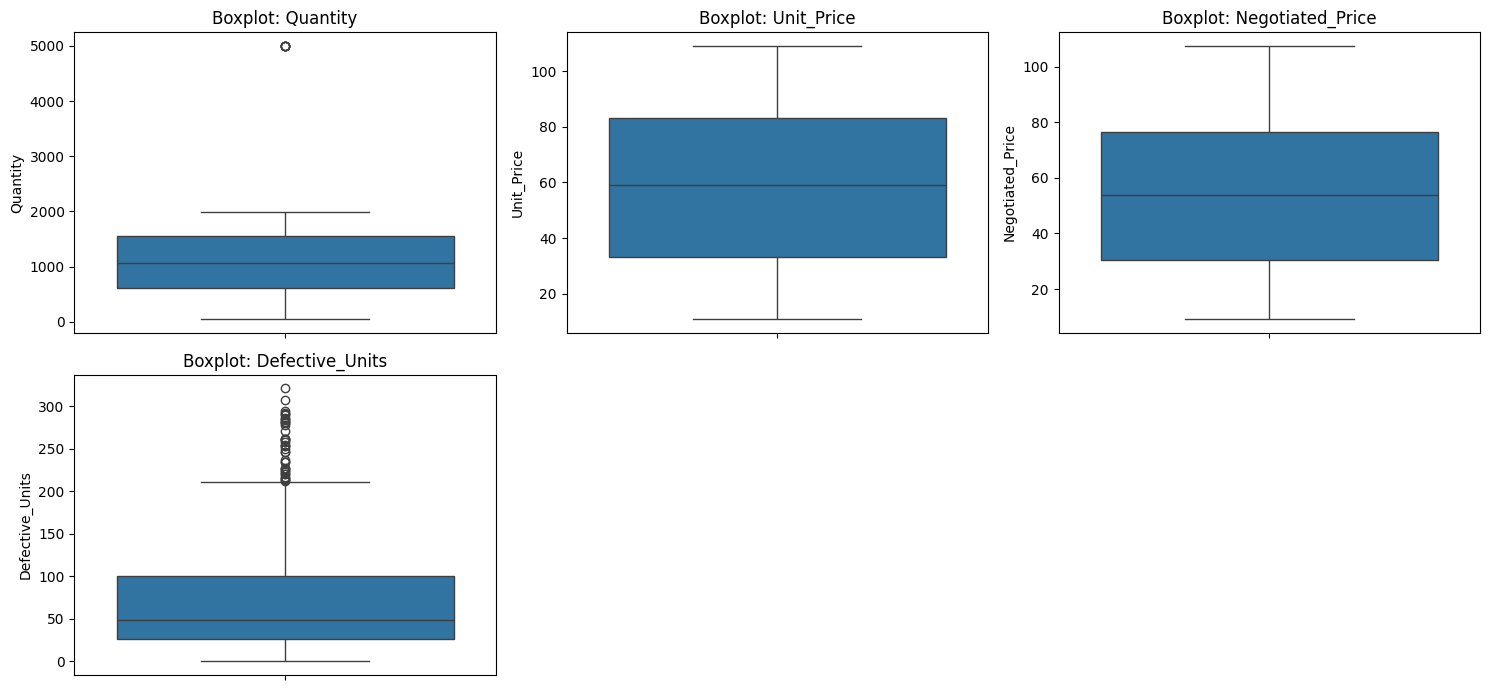


⚠️ Outliers in column 'Quantity': 6 cases


,supplier_id,Quantity
10,Epsilon_Group,5000
11,Beta_Supplies,5000
12,Beta_Supplies,5000
13,Beta_Supplies,5000
14,Delta_Logistics,5000
15,Beta_Supplies,5000



⚠️ Outliers in column 'Unit_Price': 0 cases


,supplier_id,Unit_Price



⚠️ Outliers in column 'Negotiated_Price': 0 cases


,supplier_id,Negotiated_Price



⚠️ Outliers in column 'Defective_Units': 40 cases


,supplier_id,Defective_Units
1,Delta_Logistics,235.0
53,Delta_Logistics,262.0
85,Delta_Logistics,262.0
86,Delta_Logistics,278.0
87,Delta_Logistics,228.0
132,Delta_Logistics,282.0
148,Beta_Supplies,216.0
170,Delta_Logistics,235.0
199,Delta_Logistics,291.0
225,Delta_Logistics,250.0


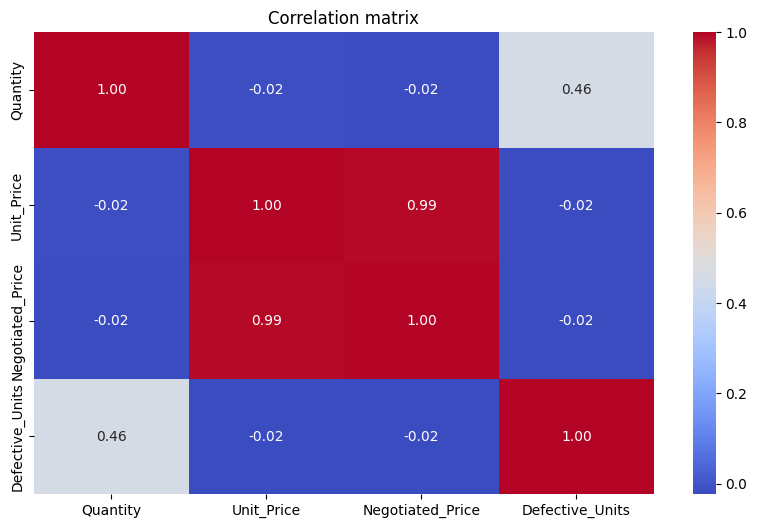


Top correlation pairs:
Unit_Price        Negotiated_Price    0.994602
Negotiated_Price  Unit_Price          0.994602
Defective_Units   Quantity            0.459988
Quantity          Defective_Units     0.459988
Defective_Units   Negotiated_Price    0.023030
dtype: float64


In [ ]:
# 2 Exploratory Data Analysis (EDA) – adaptable for any number of numerical columns

# Preview the data
print("Data preview:")
display(df.head())

# Data types and missing values
print("\nData types:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isnull().sum())

# Basic statistics
print("\nDescriptive statistics:")
display(df.describe())

# Numerical columns (exclude supplier_id if numeric)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if "supplier_id" in num_cols:
    num_cols.remove("supplier_id")

k = len(num_cols)
if k == 0:
    print("\n[INFO] No numerical columns found — skipping histograms, boxplots, and correlations.")
else:
    # Histograms (grid adjusted to number of features)
    cols = 3 if k >= 3 else (2 if k == 2 else 1)
    rows = int(np.ceil(k / cols))
    axes = df[num_cols].hist(figsize=(5*cols, 3.5*rows), bins=20)

    # Normalize axes structure
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])
    axes = axes.flatten()

    for ax, col in zip(axes, num_cols):
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        ax.set_title(f"Histogram: {col}")

    plt.suptitle("Distribution of numerical features", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Boxplots (grid adjusted to number of features)
    plt.figure(figsize=(5*cols, 3.5*rows))
    for i, col in enumerate(num_cols, 1):
        ax = plt.subplot(rows, cols, i)
        sns.boxplot(y=df[col], ax=ax)
        ax.set_title(f"Boxplot: {col}")
        ax.set_ylabel(col)
    plt.tight_layout()
    plt.show()

    # Outlier detection (IQR) + show supplier IDs if present
    def find_outliers(col):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        mask = (df[col] < lower) | (df[col] > upper)
        cols_to_show = ['supplier_id', col] if 'supplier_id' in df.columns else [col]
        return df.loc[mask, cols_to_show]

    for c in num_cols:
        out = find_outliers(c)
        print(f"\n⚠️ Outliers in column '{c}': {len(out)} cases")
        display(out)

    # Correlation matrix (if at least 2 numerical features)
    if len(num_cols) >= 2:
        plt.figure(figsize=(10, 6))
        sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
        plt.title("Correlation matrix")
        plt.show()

        corr_matrix = df[num_cols].corr().abs()
        pairs = corr_matrix.unstack().sort_values(ascending=False)
        pairs = pairs[pairs < 1]  # remove diagonal
        print("\nTop correlation pairs:")
        print(pairs.head(5))
    else:
        print("\n[INFO] Not enough numerical columns to compute correlations.")



### Data Preparation

In this step, the dataset is cleaned and transformed before modeling. Numerical features are selected, missing values are filled using the median, and all features are standardized to ensure equal influence during PCA and clustering. Highly correlated features are optionally removed to avoid redundancy and noise. The final output is a scaled numerical dataset ready for further analysis.


In [ ]:
# 3 Data preparation for modeling

# Copy original dataframe
data_model = df.copy()

# Select numerical columns (if present)
num_cols = data_model.select_dtypes(include=[np.number]).columns

# Remove supplier_id if stored as numeric
if 'supplier_id' in num_cols:
    num_cols = num_cols.drop('supplier_id')

data_model = data_model[num_cols]

# Fill missing values using median
data_model = data_model.fillna(data_model.median())

# Standardize features (important for PCA and clustering)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_model)

# Preserve dataframe structure after scaling
data_scaled = pd.DataFrame(data_scaled, columns=data_model.columns, index=df.index)

print("Scaled data preview (first 5 rows):")
display(data_scaled.head())

# Optionally remove highly correlated features (> 0.9)
corr_matrix = data_scaled.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

if len(to_drop) > 0:
    print("\nRemoving highly correlated columns:", to_drop)
    data_scaled = data_scaled.drop(columns=to_drop)
else:
    print("\nNo highly correlated columns detected.")

print("\nFinal shape after preparation:", data_scaled.shape)


Scaled data preview (first 5 rows):


,Quantity,Unit_Price,Negotiated_Price,Defective_Units
0,0.125635,-1.358598,-1.374743,-0.334945
1,0.639979,-0.675272,-0.625839,2.591715
2,-0.285221,1.325566,1.480140,-0.460823
3,0.385124,1.480107,1.605149,0.656343
4,0.131814,0.206037,0.263411,1.584692



Removing highly correlated columns: ['Negotiated_Price']

Final shape after preparation: (777, 3)


###  Dimensionality Reduction (PCA)

In this step, Principal Component Analysis (PCA) is applied to reduce the dimensionality of the dataset while preserving most of its variance. PCA transforms the original features into a smaller number of components that capture the dominant patterns in the data. This helps to simplify clustering, reduce noise, and improve visualization. We select the minimum number of components that explain at least 90% of the total variance and use them for further analysis.


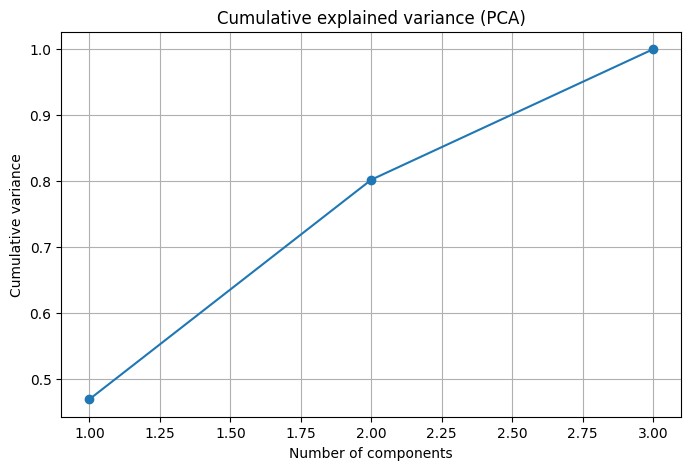

PCA components explaining ≥ 90% variance: 3

PCA-transformed data preview (first 10 rows):


,PC1,PC2,PC3
0,-0.066530,-1.366986,0.317309
1,2.321155,-0.529090,-1.383783
2,-0.605746,1.290902,0.132204
3,0.646670,1.522601,-0.182558
4,1.199091,0.284468,-1.025833
5,-0.315766,0.368380,0.405409
6,1.041000,-0.187138,0.454544
7,-0.491492,-0.794430,0.531751
8,0.885318,-0.461751,0.436843
9,-1.738366,0.560918,-0.312035


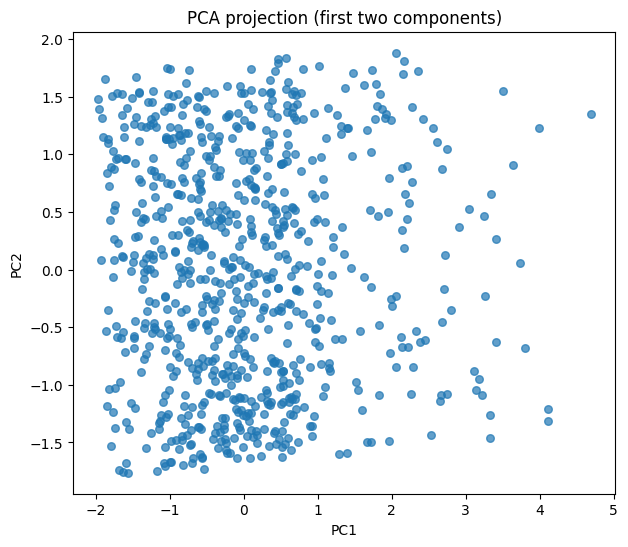

In [ ]:
# 4 Dimensionality reduction (PCA)

# Fit PCA on all features (no component limit yet)
pca_full = PCA()
pca_full.fit(data_scaled)

# Cumulative explained variance
explained_var = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var) + 1), explained_var, marker='o')
plt.title('Cumulative explained variance (PCA)')
plt.xlabel('Number of components')
plt.ylabel('Cumulative variance')
plt.grid(True)
plt.show()
# print(pca_full.explained_variance_ratio_)

# Choose minimum number of components to explain ≥ 90% variance
n_components = np.argmax(explained_var >= 0.90) + 1
print(f"PCA components explaining ≥ 90% variance: {n_components}")

# Reduce dimensionality
pca = PCA(n_components=n_components)
data_pca_arr = pca.fit_transform(data_scaled)

# Back to DataFrame (preserve index/column names)
data_pca = pd.DataFrame(
    data_pca_arr,
    columns=[f"PC{i+1}" for i in range(n_components)],
    index=data_scaled.index
)

print("\nPCA-transformed data preview (first 10 rows):")
display(data_pca.head(10))

# 2D visualization using the first two components (if available)
if n_components >= 2:
    plt.figure(figsize=(7, 6))
    plt.scatter(data_pca['PC1'], data_pca['PC2'], s=30, alpha=0.7)
    plt.title('PCA projection (first two components)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()


### Clustering using K-Means (with PCA features)

In this step, the reduced PCA components are used as input for the K-Means clustering algorithm. The optimal number of clusters is estimated using the Elbow method and validated with the Silhouette Score, which evaluates how well data points fit within their assigned groups. After selecting the best cluster count, the final K-Means model assigns each supplier to a segment, and the clusters are visualized in two-dimensional PCA space.


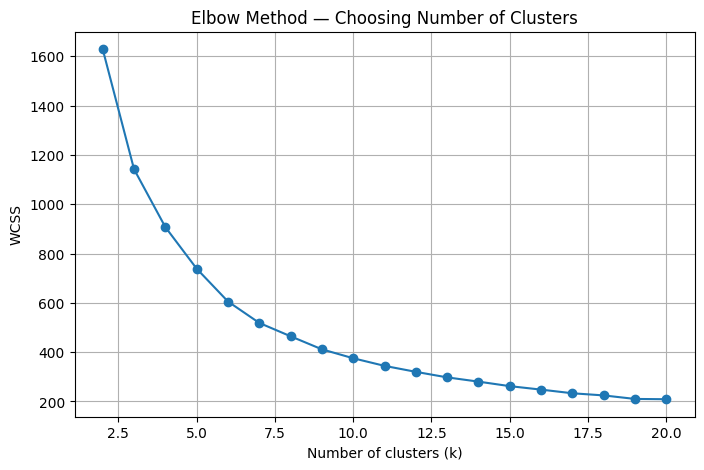

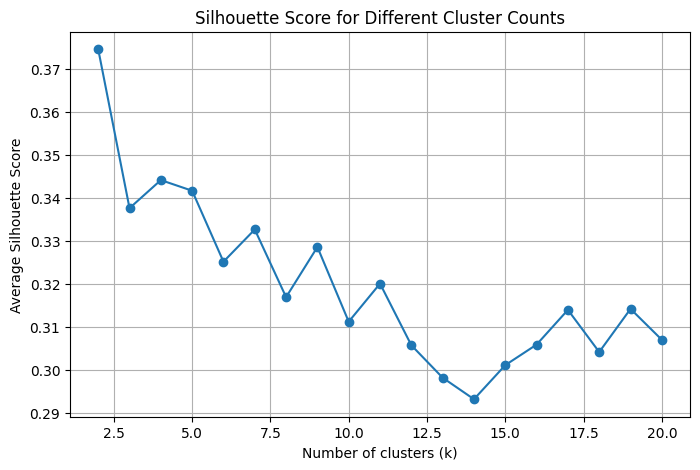

Best number of clusters based on Silhouette Score: 2

Number of observations in each cluster:
Cluster_KMeans
0    609
1    168
Name: count, dtype: int64


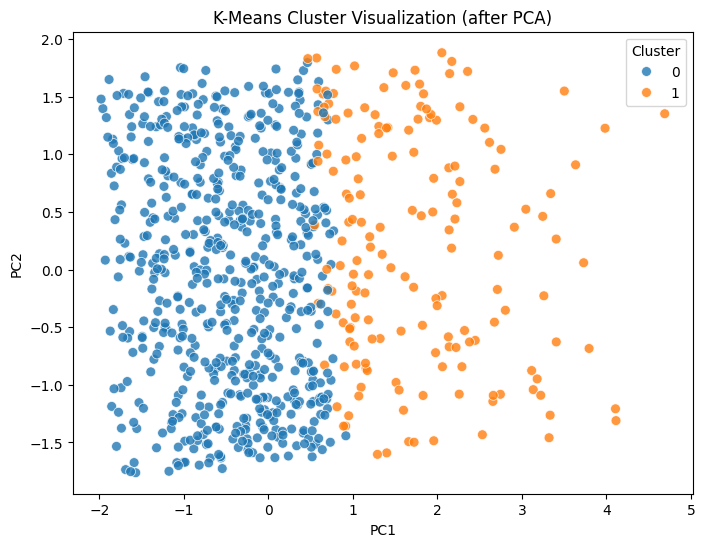

In [ ]:
# 5 Clustering — K-Means with PCA components

# Use only PCA component columns
X = data_pca.filter(regex='^PC\\d+$').copy()

# Determine the optimal number of clusters using the Elbow method
wcss = []  # Within-Cluster Sum of Squares
k_range = range(2, 21)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(list(k_range), wcss, marker='o')
plt.title('Elbow Method — Choosing Number of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

# Evaluate cluster quality using Silhouette Score
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(list(k_range), silhouette_scores, marker='o')
plt.title('Silhouette Score for Different Cluster Counts')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.grid(True)
plt.show()

# Select the best number of clusters based on maximum Silhouette Score
best_k = list(k_range)[int(np.argmax(silhouette_scores))]
print(f"Best number of clusters based on Silhouette Score: {best_k}")

# Train the final K-Means model
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
data_pca['Cluster_KMeans'] = kmeans_final.fit_predict(X)

# Show number of observations in each cluster
print("\nNumber of observations in each cluster:")
print(data_pca['Cluster_KMeans'].value_counts())

# Visualize clusters in 2D PCA space
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Cluster_KMeans',
    data=data_pca,
    s=50, alpha=0.8
)
plt.title('K-Means Cluster Visualization (after PCA)')
plt.legend(title='Cluster')
plt.show()



### Clustering using DBSCAN

This step applies the DBSCAN algorithm to identify dense regions in the PCA-reduced data. Unlike K-Means, DBSCAN does not require specifying the number of clusters and can detect noise points that do not belong to any group. Different combinations of parameters are tested, and the model with the best Silhouette Score is selected. The resulting clusters are visualized in two-dimensional PCA space.


Best DBSCAN parameters: eps=1.0, min_samples=5
Silhouette Score: 0.663

Number of points in each DBSCAN cluster:
Cluster_DBSCAN
 0    771
-1      6
Name: count, dtype: int64


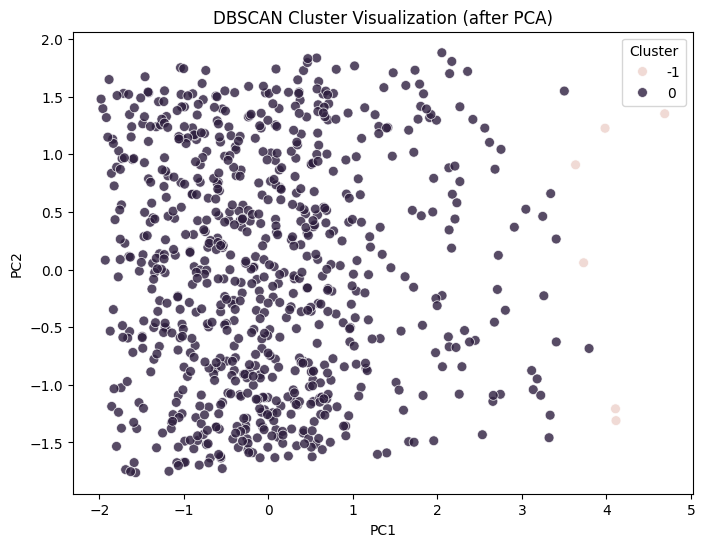

In [ ]:
# 6 Clustering — DBSCAN

# Use only PCA component columns (PC1, PC2, ...)
X = data_pca.filter(regex='^PC\\d+$').copy()

# Test several combinations of eps and min_samples
eps_values = [0.3, 0.5, 0.7, 1.0]
min_samples_values = [3, 5, 10]

best_dbscan = None
best_silhouette = -1
best_params = None

for eps in eps_values:
    for min_s in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_s)
        labels = db.fit_predict(X)

        # Skip cases where clustering makes no sense
        labs = set(labels)
        if len(labs) > 1 and not (labs == {-1}):
            score = silhouette_score(X, labels)
            if score > best_silhouette:
                best_silhouette = score
                best_dbscan = db
                best_params = (eps, min_s)

if best_dbscan:
    print(f"Best DBSCAN parameters: eps={best_params[0]}, min_samples={best_params[1]}")
    print(f"Silhouette Score: {best_silhouette:.3f}")
    data_pca['Cluster_DBSCAN'] = best_dbscan.fit_predict(X)
else:
    print("No valid DBSCAN clusters found (data too dispersed).")

# Display number of points in each cluster
if 'Cluster_DBSCAN' in data_pca.columns:
    print("\nNumber of points in each DBSCAN cluster:")
    print(data_pca['Cluster_DBSCAN'].value_counts())

    # Visualize DBSCAN clusters
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x='PC1', y='PC2',
        hue='Cluster_DBSCAN',
        data=data_pca,
        s=50, alpha=0.8
    )
    plt.title('DBSCAN Cluster Visualization (after PCA)')
    plt.legend(title='Cluster')
    plt.show()


### Cluster Evaluation and Comparison (using PCA)

This section evaluates how well clusters are formed after dimensionality reduction with PCA. Silhouette Scores measure cluster separation quality, while standardized feature profiles help interpret differences between groups. Heatmaps visualize these patterns, and auto-generated labels highlight the most influential features inside each cluster.



=== Silhouette Scores (PCA) ===
K-Means (PCA): 0.375
DBSCAN (PCA): 0.663

=== Cluster profiles (mean z-scores) — K-Means (PCA) ===


,Quantity,Unit_Price,Defective_Units
cluster,,,
0,-0.25,-0.03,-0.43
1,0.90,0.10,1.57



Cluster profiles — DBSCAN (PCA):


,Quantity,Unit_Price,Defective_Units
cluster,,,
0,-0.05,0.0,0.0


/tmp/ipython-input-1859429534.py:51: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


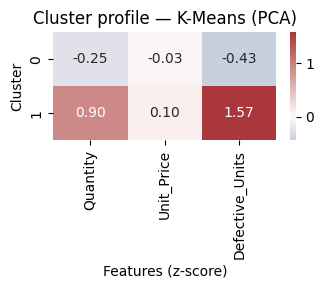

/tmp/ipython-input-1859429534.py:51: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


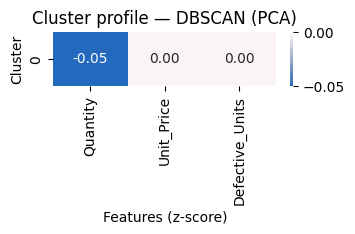


=== Top features by cluster — K-Means (PCA) ===
{0: 'Defective_Units, Quantity', 1: 'Defective_Units, Quantity'}

Top features by cluster — DBSCAN (PCA):
{0: 'Quantity, Unit_Price'}


In [ ]:
# 7 Cluster evaluation and comparison — PCA only

# Silhouette (PCA)
def safe_silhouette(X, labels):
    labs = set(labels)
    if len(labs) < 2 or labs == {-1}:
        return None
    return silhouette_score(X, labels)

print("\n=== Silhouette Scores (PCA) ===")
X_pca = data_pca.filter(regex='^PC')

# K-Means (PCA)
sil_km_pca = safe_silhouette(X_pca, data_pca['Cluster_KMeans'])
print(f"K-Means (PCA): {sil_km_pca:.3f}" if sil_km_pca is not None else "K-Means (PCA): n/a")

# DBSCAN (PCA), if available
if 'Cluster_DBSCAN' in data_pca.columns:
    sil_db_pca = safe_silhouette(X_pca, data_pca['Cluster_DBSCAN'])
    if sil_db_pca is not None:
        print(f"DBSCAN (PCA): {sil_db_pca:.3f}")

# Cluster profiles (mean z-scores) — PCA
def cluster_profile(df_scaled, labels):
    tmp = df_scaled.copy()
    tmp['cluster'] = labels.values
    if -1 in tmp['cluster'].unique():
        tmp = tmp[tmp['cluster'] != -1]
    return tmp.groupby('cluster').mean().round(2)

print("\n=== Cluster profiles (mean z-scores) — K-Means (PCA) ===")
prof_km_pca = cluster_profile(data_scaled, data_pca['Cluster_KMeans'])
display(prof_km_pca)

# DBSCAN profiles (optional)
if 'Cluster_DBSCAN' in data_pca.columns:
    prof_db_pca = cluster_profile(data_scaled, data_pca['Cluster_DBSCAN'])
    if not prof_db_pca.empty:
        print("\nCluster profiles — DBSCAN (PCA):")
        display(prof_db_pca)

# Profile heatmaps — PCA
def plot_heatmap(profile, title):
    if profile is None or profile.empty:
        return
    plt.figure(figsize=(min(12, 1.2*len(profile.columns)), 0.7*len(profile)))
    sns.heatmap(profile, annot=True, cmap='vlag', center=0, fmt='.2f')
    plt.title(title)
    plt.xlabel('Features (z-score)')
    plt.ylabel('Cluster')
    plt.tight_layout()
    plt.show()

plot_heatmap(prof_km_pca, "Cluster profile — K-Means (PCA)")

if 'Cluster_DBSCAN' in data_pca.columns:
    try:
        plot_heatmap(prof_db_pca, "Cluster profile — DBSCAN (PCA)")
    except NameError:
        pass

# Auto labels (top features per cluster)
def auto_labels(profile, top_n=2):
    if profile is None or profile.empty:
        return {}
    labels = {}
    for c in profile.index:
        feats = profile.loc[c].abs().sort_values(ascending=False).head(top_n).index
        labels[c] = ', '.join(feats)
    return labels

print("\n=== Top features by cluster — K-Means (PCA) ===")
print(auto_labels(prof_km_pca))

if 'Cluster_DBSCAN' in data_pca.columns:
    try:
        print("\nTop features by cluster — DBSCAN (PCA):")
        print(auto_labels(prof_db_pca))
    except NameError:
        pass
